In [27]:
import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

**Data Preparation - Integrity**

In [31]:
# Load Dataset and convert into DataFrame
data, attributes = arff.loadarff('dataset_54_vehicle.arff')
df = pd.DataFrame(data)

# Drop non-numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Structure of the data
for i, row in enumerate(data[:1]):
    print(f"Sample {i + 1}:")
    print("-" * 40)
    for item in row:
        print(f"{str(item):19} {str(type(item))}")
    print("-" * 40)

# Count missing values
print(df.isnull().sum())

Y = df['Class'].astype(str)

# Scale the numeric features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Convert back to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns)

# Check for attribute dependencies with arbitrary correlation threshold
correlation_matrix = scaled_df.corr()
threshold = 0.5

# Convert to upper triangle matrix (exploit symmetry)
mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
corr_pairs = correlation_matrix.where(mask).stack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Filter by threshold & sort by magnitude
significant_corrs = corr_pairs[abs(corr_pairs['Correlation']) >= threshold]
significant_corrs = significant_corrs.reindex(significant_corrs['Correlation'].abs().sort_values(ascending=False).index)

pd.set_option('display.max_rows', None)
print("Unique significant correlations (|r| ≥ 0.5):")
print(significant_corrs.to_string(index=False))

Sample 1:
----------------------------------------
95.0                <class 'numpy.float64'>
48.0                <class 'numpy.float64'>
83.0                <class 'numpy.float64'>
178.0               <class 'numpy.float64'>
72.0                <class 'numpy.float64'>
10.0                <class 'numpy.float64'>
162.0               <class 'numpy.float64'>
42.0                <class 'numpy.float64'>
20.0                <class 'numpy.float64'>
159.0               <class 'numpy.float64'>
176.0               <class 'numpy.float64'>
379.0               <class 'numpy.float64'>
184.0               <class 'numpy.float64'>
70.0                <class 'numpy.float64'>
6.0                 <class 'numpy.float64'>
16.0                <class 'numpy.float64'>
187.0               <class 'numpy.float64'>
197.0               <class 'numpy.float64'>
b'van'              <class 'numpy.bytes_'>
----------------------------------------
COMPACTNESS                  0
CIRCULARITY                  0
DISTANCE_CI

**Support Vector Machine**

In [29]:
from sklearn.svm import SVC

scoreboard_svm = []
split_sizes = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

param_grid = [
        {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100, 1000]},
        {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': ['scale']},
        {'svc__kernel': ['poly'], 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': ['scale'], 'svc__degree': [2, 3, 4]}
]

for size in split_sizes:
    print(f"\nTraining with {int(size * 100)}% of data:")

    # Seeded random stratified sampling
    X_sub, X_val, y_sub, y_val = train_test_split(scaled_df, Y, train_size=size, stratify=Y, random_state=42)

    # Pipeline with scaler* and SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC())
    ])

    # Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=1)
    grid_search.fit(X_sub, y_sub)

    # Evaluation
    Y_pred = grid_search.predict(X_val)
    print("Best parameters:", grid_search.best_params_)
    print(classification_report(y_val, Y_pred))

    results = grid_search.cv_results_
    for i in range(len(results['params'])):
        entry = {
            'split_size': size,
            'params': results['params'][i],
            'mean_test_score': results['mean_test_score'][i],
            'std_test_score': results['std_test_score'][i],
            'rank_test_score': results['rank_test_score'][i]
        }
        scoreboard_svm.append(entry)


Training with 65% of data:
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best parameters: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

         bus       0.97      0.96      0.97        77
        opel       0.75      0.64      0.69        74
        saab       0.71      0.79      0.75        76
         van       0.93      0.97      0.95        70

    accuracy                           0.84       297
   macro avg       0.84      0.84      0.84       297
weighted avg       0.84      0.84      0.84       297


Training with 70% of data:
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best parameters: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

         bus       0.97      1.00      0.98        65
        opel       0.75      0.67      0.71        64
        saab       0.73      0.78      0.76        65
         v

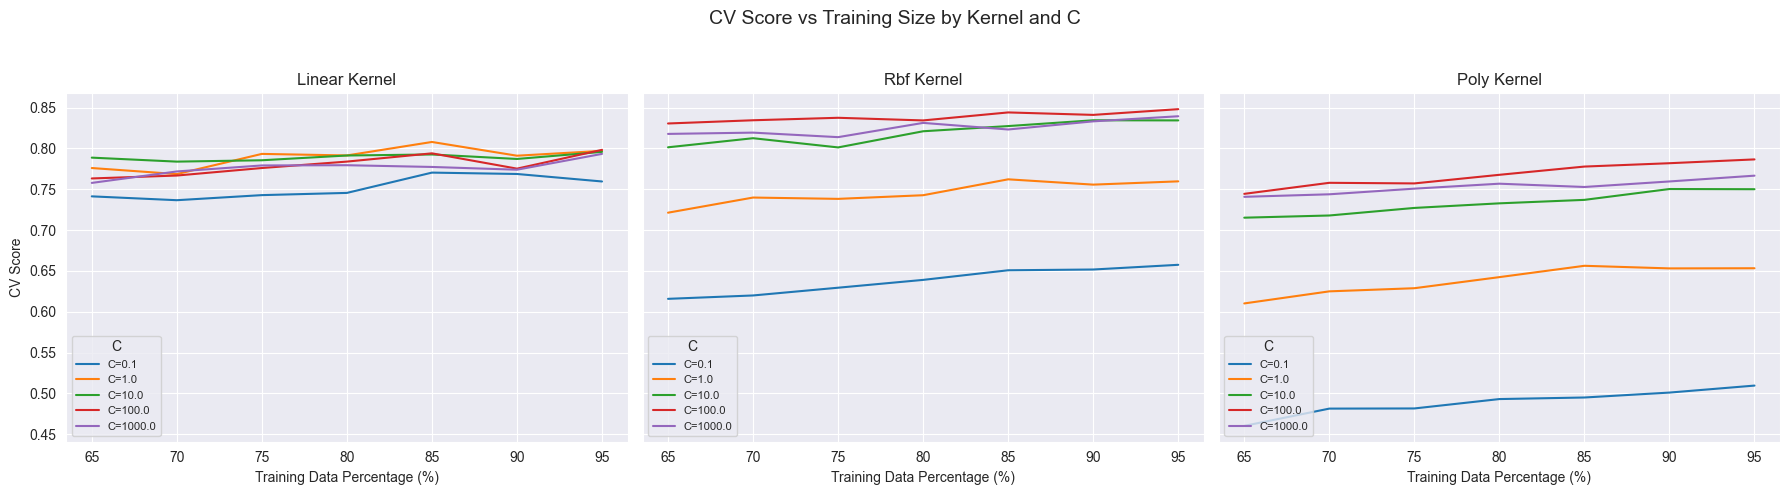


Predicted Best Overall SVM Configuration:
Split Size: 0.95
Parameters: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Mean CV Score: 0.8481
Std CV Score: 0.0219


In [88]:
cv_df = pd.DataFrame(scoreboard_svm)
cv_df['kernel'] = cv_df['params'].apply(lambda d: d.get('svc__kernel'))
cv_df['C'] = cv_df['params'].apply(lambda d: d.get('svc__C'))
cv_df['split_size_percent'] = cv_df['split_size'] * 100

# Create a unique label for each configuration
cv_df['config'] = cv_df.apply(lambda row: f"C={row['C']}", axis=1)

# Set up subplots
kernels = ['linear', 'rbf', 'poly']
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, kernel in zip(axes, kernels):
    kernel_df = cv_df[cv_df['kernel'] == kernel]
    pivot_df = kernel_df.pivot_table(index='split_size_percent', columns='config', values='mean_test_score')

    for config in pivot_df.columns:
        ax.plot(pivot_df.index, pivot_df[config], label=config)

    ax.set_title(f"{kernel.capitalize()} Kernel")
    ax.set_xlabel('Training Data Percentage (%)')
    ax.grid(True)
    ax.legend(title='C', fontsize=8)

axes[0].set_ylabel('CV Score')
plt.suptitle('CV Score vs Training Size by Kernel and C', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

best_entry = cv_df.sort_values(by='mean_test_score', ascending=False).iloc[0]

# Print best configuration
print("\nPredicted Best Overall SVM Configuration:")
print(f"Split Size: {best_entry['split_size']}")
print(f"Parameters: {best_entry['params']}")
print(f"Mean CV Score: {best_entry['mean_test_score']:.4f}")
print(f"Std CV Score: {best_entry['std_test_score']:.4f}")

*Best overall Tested SVM Configuration:*

Training with 75% of data
Best parameters: `{'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}`

| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| bus          | 1.00      | 1.00   | 1.00     | 55      |
| opel         | 0.77      | 0.70   | 0.73     | 53      |
| saab         | 0.74      | 0.80   | 0.77     | 54      |
| van          | 0.96      | 0.98   | 0.97     | 50      |
| **accuracy** |           |        | 0.87     | 212     |
| **macro avg**| 0.87      | 0.87   | 0.87     | 212     |
| **weighted avg** | 0.87  | 0.87   | 0.87     | 212     |

PCA

In [85]:
from sklearn.decomposition import PCA

scoreboard_pca_svm = []

split_sizes = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

param_grid = [
        {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100, 1000], 'pca__n_components': [0.995, 0.996, 0.997, 0.998, 0.999]},
        {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': ['scale'], 'pca__n_components': [0.995, 0.996, 0.997, 0.998, 0.999]},
]

for size in split_sizes:
    print(f"\nTraining with {int(size * 100)}% of data:")

    # Seeded random stratified sampling
    X_sub, X_val, y_sub, y_val = train_test_split(scaled_df, Y, train_size=size, stratify=Y, random_state=42)

    # Pipeline with scaler* and SVC
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('svc', SVC())
        ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=0)
    grid_search.fit(X_sub, y_sub)

    best_pipeline = grid_search.best_estimator_
    print("Selected PCA n_components:", best_pipeline.named_steps['pca'].n_components_)

    # Evaluation
    Y_pred = grid_search.predict(X_val)
    print("Best parameters:", grid_search.best_params_)
    print(classification_report(y_val, Y_pred))

    results = grid_search.cv_results_
    for i in range(len(results['params'])):
        entry = {
            'split_size': size,
            'params': results['params'][i],
            'mean_test_score': results['mean_test_score'][i],
            'std_test_score': results['std_test_score'][i],
            'rank_test_score': results['rank_test_score'][i]
        }
        scoreboard_pca_svm.append(entry)


Training with 65% of data:
Selected PCA n_components: 14
Best parameters: {'pca__n_components': 0.998, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

         bus       0.99      0.97      0.98        77
        opel       0.70      0.65      0.67        74
        saab       0.69      0.74      0.71        76
         van       0.94      0.96      0.95        70

    accuracy                           0.83       297
   macro avg       0.83      0.83      0.83       297
weighted avg       0.83      0.83      0.83       297


Training with 70% of data:
Selected PCA n_components: 16
Best parameters: {'pca__n_components': 0.999, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

         bus       0.97      0.98      0.98        65
        opel       0.77      0.69      0.73        64
        saab       0.74      0.80      0.77        65
         van       0

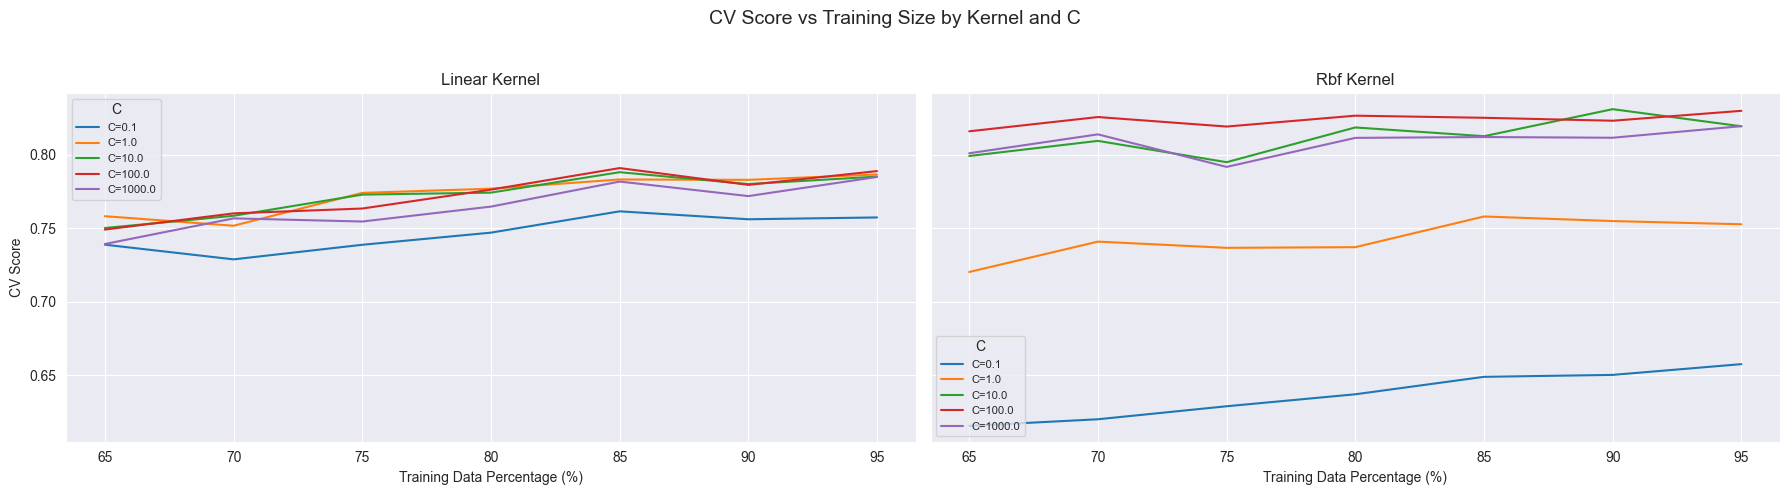


Predicted Best Overall PCA+SVM Configuration:
Split Size: 0.95
Parameters: {'pca__n_components': 0.999, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Mean CV Score: 0.8481
Std CV Score: 0.0180


In [89]:
cv_df = pd.DataFrame(scoreboard_pca_svm)
cv_df['kernel'] = cv_df['params'].apply(lambda d: d.get('svc__kernel'))
cv_df['C'] = cv_df['params'].apply(lambda d: d.get('svc__C'))
cv_df['split_size_percent'] = cv_df['split_size'] * 100

# Create a unique label for each configuration
cv_df['config'] = cv_df.apply(lambda row: f"C={row['C']}", axis=1)

# Set up subplots
kernels = ['linear', 'rbf']
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

for ax, kernel in zip(axes, kernels):
    kernel_df = cv_df[cv_df['kernel'] == kernel]
    pivot_df = kernel_df.pivot_table(index='split_size_percent', columns='config', values='mean_test_score')

    for config in pivot_df.columns:
        ax.plot(pivot_df.index, pivot_df[config], label=config)

    ax.set_title(f"{kernel.capitalize()} Kernel")
    ax.set_xlabel('Training Data Percentage (%)')
    ax.grid(True)
    ax.legend(title='C', fontsize=8)

axes[0].set_ylabel('CV Score')
plt.suptitle('CV Score vs Training Size by Kernel and C', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

best_entry = cv_df.sort_values(by='mean_test_score', ascending=False).iloc[0]

# Print best configuration
print("\nPredicted Best Overall PCA+SVM Configuration:")
print(f"Split Size: {best_entry['split_size']}")
print(f"Parameters: {best_entry['params']}")
print(f"Mean CV Score: {best_entry['mean_test_score']:.4f}")
print(f"Std CV Score: {best_entry['std_test_score']:.4f}")

*Best overall Tested SVM Configuration:*

Training with 75% of data:
Selected PCA n_components: 16
Best parameters: {'pca__n_components': 0.999, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| bus          | 1.00      | 1.00   | 1.00     | 55      |
| opel         | 0.77      | 0.70   | 0.73     | 53      |
| saab         | 0.75      | 0.81   | 0.78     | 54      |
| van          | 0.96      | 0.96   | 0.96     | 50      |
| **accuracy** |           |        | 0.87     | 212     |
| **macro avg**| 0.87      | 0.87   | 0.87     | 212     |
| **weighted avg** | 0.87  | 0.87   | 0.87     | 212     |


**Random Forest**

In [35]:
from sklearn.ensemble import RandomForestClassifier

scoreboard_rf = []
split_sizes = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

param_grid = {
    'rf__n_estimators': [100, 300], # < 500
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__criterion': ['gini', 'entropy'],
}

for size in split_sizes:
    print(f"\nTraining with {int(size * 100)}% of data:")

    # Seeded random stratified sampling
    X_sub, X_val, y_sub, y_val = train_test_split(scaled_df, Y, train_size=size, stratify=Y, random_state=42)

    # Pipeline with scaler and RF
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier())
    ])

    # Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=1)
    grid_search.fit(X_sub, y_sub)

    # Evaluation
    Y_pred = grid_search.predict(X_val)
    print("Best parameters:", grid_search.best_params_)
    print(classification_report(y_val, Y_pred))

    results = grid_search.cv_results_
    for i in range(len(results['params'])):
        entry = {
            'split_size': size,
            'params': results['params'][i],
            'mean_test_score': results['mean_test_score'][i],
            'std_test_score': results['std_test_score'][i],
            'rank_test_score': results['rank_test_score'][i]
        }
        scoreboard_rf.append(entry)


Training with 65% of data:
Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Best parameters: {'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
              precision    recall  f1-score   support

         bus       0.92      0.99      0.95        77
        opel       0.63      0.35      0.45        74
        saab       0.54      0.68      0.60        76
         van       0.90      0.99      0.94        70

    accuracy                           0.75       297
   macro avg       0.75      0.75      0.74       297
weighted avg       0.75      0.75      0.73       297


Training with 70% of data:
Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Best parameters: {'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
              precision    recall

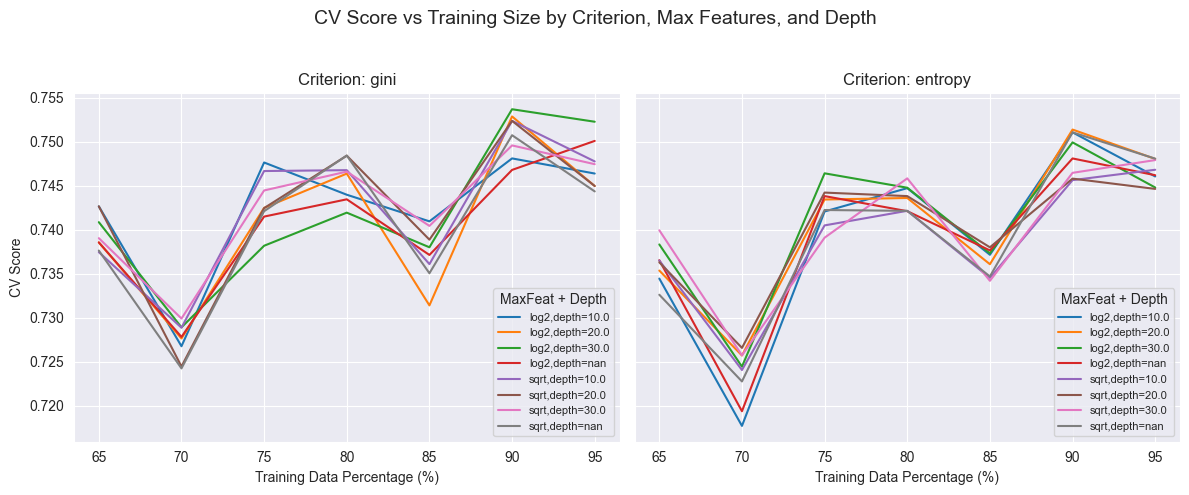


Predicted Best Overall RF Configuration:
Split Size: 0.9
Parameters: {'rf__criterion': 'gini', 'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Mean CV Score: 0.7701
Std CV Score: 0.0461


In [90]:
cv_df = pd.DataFrame(scoreboard_rf)

# Extract parameters
cv_df['criterion'] = cv_df['params'].apply(lambda d: d.get('rf__criterion'))
cv_df['max_features'] = cv_df['params'].apply(lambda d: d.get('rf__max_features'))
cv_df['max_depth'] = cv_df['params'].apply(lambda d: d.get('rf__max_depth'))
cv_df['min_samples_split'] = cv_df['params'].apply(lambda d: d.get('rf__min_samples_split'))
cv_df['min_samples_leaf'] = cv_df['params'].apply(lambda d: d.get('rf__min_samples_leaf'))
cv_df['split_size_percent'] = cv_df['split_size'] * 100

# Create a config label
cv_df['config'] = cv_df.apply(lambda row: f"{row['max_features']},depth={row['max_depth']}", axis=1)

# Facet by criterion
criteria = cv_df['criterion'].unique()
fig, axes = plt.subplots(1, len(criteria), figsize=(6 * len(criteria), 5), sharey=True)

for ax, criterion in zip(axes, criteria):
    crit_df = cv_df[cv_df['criterion'] == criterion]
    pivot_df = crit_df.pivot_table(index='split_size_percent', columns='config', values='mean_test_score')

    for config in pivot_df.columns:
        ax.plot(pivot_df.index, pivot_df[config], label=config)

    ax.set_title(f"Criterion: {criterion}")
    ax.set_xlabel('Training Data Percentage (%)')
    ax.grid(True)
    ax.legend(title='MaxFeat + Depth', fontsize=8)

axes[0].set_ylabel('CV Score')
plt.suptitle('CV Score vs Training Size by Criterion, Max Features, and Depth', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

best_entry = cv_df.sort_values(by='mean_test_score', ascending=False).iloc[0]

# Print best configuration
print("\nPredicted Best Overall RF Configuration:")
print(f"Split Size: {best_entry['split_size']}")
print(f"Parameters: {best_entry['params']}")
print(f"Mean CV Score: {best_entry['mean_test_score']:.4f}")
print(f"Std CV Score: {best_entry['std_test_score']:.4f}")

*Best overall Tested RF Configuration:*

Training with 70% of data:
Best parameters: {'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}

| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| bus          | 0.90      | 0.98   | 0.94     | 65      |
| opel         | 0.64      | 0.45   | 0.53     | 64      |
| saab         | 0.56      | 0.65   | 0.60     | 65      |
| van          | 0.92      | 0.97   | 0.94     | 60      |
| **accuracy** |           |        | 0.76     | 254     |
| **macro avg**| 0.76      | 0.76   | 0.75     | 254     |
| **weighted avg** | 0.75  | 0.76   | 0.75     | 254     |




*Feature Selection*

In [55]:
from sklearn.feature_selection import RFE

rf = RandomForestClassifier()
rfe = RFE(estimator=rf, n_features_to_select=1)

rfe.fit(scaled_df, Y)

selected_features = scaled_df.columns[rfe.support_]
print("Selected features:", selected_features.tolist())

ranking_df = pd.DataFrame({
    'Feature': scaled_df.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

print("\nAll features ranked:")
for _, row in ranking_df.iterrows():
    print(f"{row['Ranking']} {row['Feature']}")

sorted_features = ranking_df['Feature'].tolist()

Selected features: ['SCALED_VARIANCE_MINOR']

All features ranked:
1 SCALED_VARIANCE_MINOR
2 SCALED_VARIANCE_MAJOR
3 MAX.LENGTH_ASPECT_RATIO
4 MAX.LENGTH_RECTANGULARITY
5 SCATTER_RATIO
6 DISTANCE_CIRCULARITY
7 COMPACTNESS
8 ELONGATEDNESS
9 HOLLOWS_RATIO
10 PR.AXIS_ASPECT_RATIO
11 SKEWNESS_ABOUT_MAJOR
12 SCALED_RADIUS_OF_GYRATION
13 RADIUS_RATIO
14 CIRCULARITY
15 KURTOSIS_ABOUT_MINOR
16 SKEWNESS_ABOUT_MINOR
17 PR.AXIS_RECTANGULARITY
18 KURTOSIS_ABOUT_MAJOR


In [56]:
scoreboard_rfe_rf = []

# Param grid
param_grid = {
    'rf__n_estimators': [100, 300], # < 500
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__criterion': ['gini', 'entropy'],
}

split_sizes = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Iterate over number of top features
for n_features in range(1, len(sorted_features)):
    selected = sorted_features[:n_features]
    print(f"\n▶ Using top {n_features} features: {selected}")

    X_selected = scaled_df[selected]

    for size in split_sizes:
        print(f"\nTraining with {int(size * 100)}% of data:")

        X_sub, X_val, y_sub, y_val = train_test_split(X_selected, Y, train_size=size, stratify=Y, random_state=42)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier()),
        ])

        grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=0)
        grid_search.fit(X_sub, y_sub)

        Y_pred = grid_search.predict(X_val)
        print("Best parameters:", grid_search.best_params_)
        print(classification_report(y_val, Y_pred))

        results = grid_search.cv_results_
        for i in range(len(results['params'])):
            entry = {
                'n_features': n_features,
                'features': selected,
                'split_size': size,
                'params': results['params'][i],
                'mean_test_score': results['mean_test_score'][i],
                'std_test_score': results['std_test_score'][i],
                'rank_test_score': results['rank_test_score'][i]
            }
            scoreboard_rfe_rf.append(entry)


▶ Using top 1 features: ['SCALED_VARIANCE_MINOR']

Training with 65% of data:
Best parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
              precision    recall  f1-score   support

         bus       0.63      0.61      0.62        77
        opel       0.39      0.31      0.35        74
        saab       0.40      0.43      0.42        76
         van       0.60      0.70      0.65        70

    accuracy                           0.51       297
   macro avg       0.51      0.51      0.51       297
weighted avg       0.51      0.51      0.51       297


Training with 70% of data:
Best parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
              precision    recall  f1-score   support

         bus       0.61      0.62      0.61        65

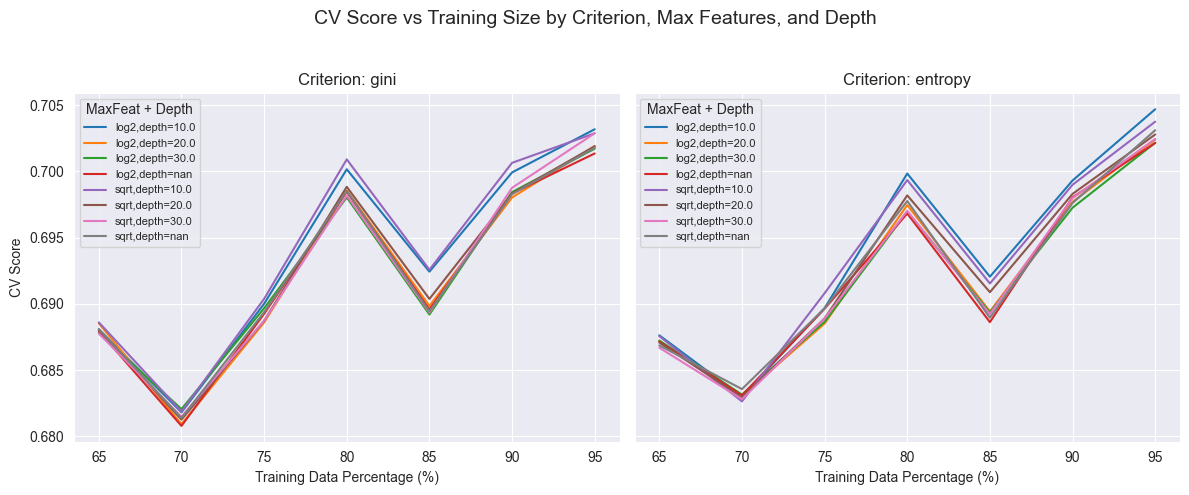


Predicted Best Overall RF Configuration:
Split Size: 0.95
Parameters: {'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Mean CV Score: 0.7696
Std CV Score: 0.0349


In [91]:
cv_df = pd.DataFrame(scoreboard_rfe_rf)

# Extract parameters
cv_df['criterion'] = cv_df['params'].apply(lambda d: d.get('rf__criterion'))
cv_df['max_features'] = cv_df['params'].apply(lambda d: d.get('rf__max_features'))
cv_df['max_depth'] = cv_df['params'].apply(lambda d: d.get('rf__max_depth'))
cv_df['min_samples_split'] = cv_df['params'].apply(lambda d: d.get('rf__min_samples_split'))
cv_df['min_samples_leaf'] = cv_df['params'].apply(lambda d: d.get('rf__min_samples_leaf'))
cv_df['split_size_percent'] = cv_df['split_size'] * 100

# Create a config label
cv_df['config'] = cv_df.apply(lambda row: f"{row['max_features']},depth={row['max_depth']}", axis=1)

# Facet by criterion
criteria = cv_df['criterion'].unique()
fig, axes = plt.subplots(1, len(criteria), figsize=(6 * len(criteria), 5), sharey=True)

for ax, criterion in zip(axes, criteria):
    crit_df = cv_df[cv_df['criterion'] == criterion]
    pivot_df = crit_df.pivot_table(index='split_size_percent', columns='config', values='mean_test_score')

    for config in pivot_df.columns:
        ax.plot(pivot_df.index, pivot_df[config], label=config)

    ax.set_title(f"Criterion: {criterion}")
    ax.set_xlabel('Training Data Percentage (%)')
    ax.grid(True)
    ax.legend(title='MaxFeat + Depth', fontsize=8)

axes[0].set_ylabel('CV Score')
plt.suptitle('CV Score vs Training Size by Criterion, Max Features, and Depth', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

best_entry = cv_df.sort_values(by='mean_test_score', ascending=False).iloc[0]

# Print best configuration
print("\nPredicted Best Overall RF Configuration:")
print(f"Split Size: {best_entry['split_size']}")
print(f"Parameters: {best_entry['params']}")
print(f"Mean CV Score: {best_entry['mean_test_score']:.4f}")
print(f"Std CV Score: {best_entry['std_test_score']:.4f}")

*Best overall Tested RFE+RF Configuration:*

Training with 70% of data:
Best parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
              precision    recall  f1-score   support


| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| bus          | 0.94      | 0.98   | 0.96     | 65      |
| opel         | 0.69      | 0.48   | 0.57     | 64      |
| saab         | 0.59      | 0.71   | 0.64     | 65      |
| van          | 0.92      | 0.97   | 0.94     | 60      |
| **accuracy** |           |        | 0.78     | 254     |
| **macro avg**| 0.79      | 0.79   | 0.78     | 254     |
| **weighted avg** | 0.78  | 0.78   | 0.78     | 254     |


**KNN**

In [58]:
from sklearn.neighbors import KNeighborsClassifier

scoreboard_knn = []
split_sizes = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

param_grid = {
    'knn__n_neighbors': [i for i in range(1, 10)], # < 10
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],  # L1 = Manhattan, L2 = Euclidean
    'pca__n_components': [0.995, 0.996, 0.997, 0.998, 0.999]
    }

for size in split_sizes:
    print(f"\nTraining with {int(size * 100)}% of data:")

    # Seeded random stratified sampling
    X_sub, X_val, y_sub, y_val = train_test_split(scaled_df, Y, train_size=size, stratify=Y, random_state=42)

    # Pipeline with scaler and KNN
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

    # Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=1)
    grid_search.fit(X_sub, y_sub)

    # Evaluation
    Y_pred = grid_search.predict(X_val)
    print("Best parameters:", grid_search.best_params_)
    print(classification_report(y_val, Y_pred))

    results = grid_search.cv_results_
    for i in range(len(results['params'])):
        entry = {
            'split_size': size,
            'params': results['params'][i],
            'mean_test_score': results['mean_test_score'][i],
            'std_test_score': results['std_test_score'][i],
            'rank_test_score': results['rank_test_score'][i]
        }
        scoreboard_knn.append(entry)


Training with 65% of data:
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters: {'knn__n_neighbors': 4, 'knn__p': 1, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

         bus       0.91      0.96      0.94        77
        opel       0.50      0.35      0.41        74
        saab       0.48      0.58      0.53        76
         van       0.89      0.93      0.91        70

    accuracy                           0.70       297
   macro avg       0.70      0.70      0.70       297
weighted avg       0.70      0.70      0.69       297


Training with 70% of data:
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters: {'knn__n_neighbors': 4, 'knn__p': 1, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

         bus       0.93      0.95      0.94        65
        opel       0.46      0.48      0.47        64
        saab       0.48      0.46      0.47        65
   

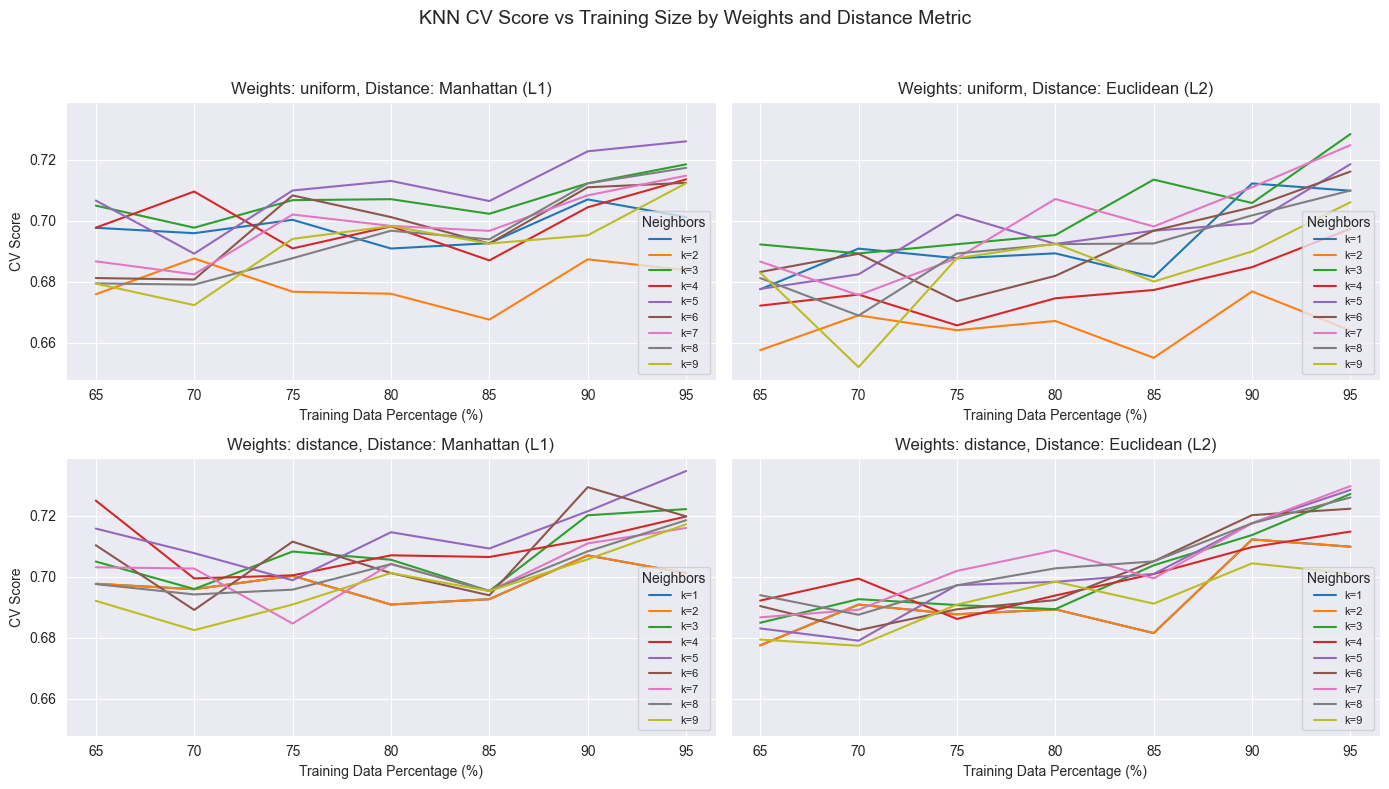


Predicted Best Overall RF Configuration:
Split Size: 0.95
Parameters: {'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
Mean CV Score: 0.7347
Std CV Score: 0.0386


In [92]:
cv_df = pd.DataFrame(scoreboard_knn)

cv_df['p'] = cv_df['params'].apply(lambda d: d.get('knn__p'))  # 1 = Manhattan, 2 = Euclidean
cv_df['weights'] = cv_df['params'].apply(lambda d: d.get('knn__weights'))
cv_df['n_neighbors'] = cv_df['params'].apply(lambda d: d.get('knn__n_neighbors'))
cv_df['split_size_percent'] = cv_df['split_size'] * 100
cv_df['config'] = cv_df.apply(lambda row: f"k={row['n_neighbors']}", axis=1)

weights = ['uniform', 'distance']
metrics = [1, 2]  # p values
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

for i, weight in enumerate(weights):
    for j, p_val in enumerate(metrics):
        subset = cv_df[(cv_df['weights'] == weight) & (cv_df['p'] == p_val)]
        pivot_df = subset.pivot_table(index='split_size_percent', columns='config', values='mean_test_score')

        ax = axes[i][j]
        sorted_configs = sorted(pivot_df.columns, key=lambda x: int(x.split('=')[1]))
        for config in sorted_configs:
            ax.plot(pivot_df.index, pivot_df[config], label=config)


        label = 'Manhattan (L1)' if p_val == 1 else 'Euclidean (L2)'
        ax.set_title(f"Weights: {weight}, Distance: {label}")
        ax.set_xlabel('Training Data Percentage (%)')
        ax.grid(True)
        ax.legend(title='Neighbors', fontsize=8)

axes[0][0].set_ylabel('CV Score')
axes[1][0].set_ylabel('CV Score')
plt.suptitle('KNN CV Score vs Training Size by Weights and Distance Metric', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

best_entry = cv_df.sort_values(by='mean_test_score', ascending=False).iloc[0]

# Print best configuration
print("\nPredicted Best Overall RF Configuration:")
print(f"Split Size: {best_entry['split_size']}")
print(f"Parameters: {best_entry['params']}")
print(f"Mean CV Score: {best_entry['mean_test_score']:.4f}")
print(f"Std CV Score: {best_entry['std_test_score']:.4f}")

*Best overall Tested KNN Configuration:*

Training with 85% of data:
Best parameters: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| bus          | 0.97      | 0.97   | 0.97     | 33      |
| opel         | 0.52      | 0.38   | 0.44     | 32      |
| saab         | 0.53      | 0.72   | 0.61     | 32      |
| van          | 0.93      | 0.87   | 0.90     | 30      |
| **accuracy** |           |        | 0.73     | 127     |
| **macro avg**| 0.74      | 0.73   | 0.73     | 127     |
| **weighted avg** | 0.74  | 0.73   | 0.73     | 127     |





PCA

In [68]:
scoreboard_pca_knn = []

split_sizes = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

param_grid = {
    'knn__n_neighbors': [i for i in range(1, 18)], #NN < 18
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2], # L1 = Manhattan, L2 = Euclidean
    'pca__n_components': [0.995, 0.996, 0.997, 0.998]
    }

for size in split_sizes:
    print(f"\nTraining with {int(size * 100)}% of data:")

    # Seeded random stratified sampling
    X_sub, X_val, y_sub, y_val = train_test_split(scaled_df, Y, train_size=size, stratify=Y, random_state=42)

    # Pipeline with scaler* and KNN
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('knn', KNeighborsClassifier())
        ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=0)
    grid_search.fit(X_sub, y_sub)

    best_pipeline = grid_search.best_estimator_
    print("Selected PCA n_components:", best_pipeline.named_steps['pca'].n_components_)

    # Evaluation
    Y_pred = grid_search.predict(X_val)
    print("Best parameters:", grid_search.best_params_)
    print(classification_report(y_val, Y_pred))

    results = grid_search.cv_results_
    for i in range(len(results['params'])):
        entry = {
            'split_size': size,
            'params': results['params'][i],
            'mean_test_score': results['mean_test_score'][i],
            'std_test_score': results['std_test_score'][i],
            'rank_test_score': results['rank_test_score'][i]
        }
        scoreboard_pca_knn.append(entry)


Training with 65% of data:
Selected PCA n_components: 14
Best parameters: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform', 'pca__n_components': 0.998}
              precision    recall  f1-score   support

         bus       0.87      0.95      0.91        77
        opel       0.57      0.51      0.54        74
        saab       0.56      0.58      0.57        76
         van       0.90      0.87      0.88        70

    accuracy                           0.73       297
   macro avg       0.72      0.73      0.73       297
weighted avg       0.72      0.73      0.72       297


Training with 70% of data:
Selected PCA n_components: 14
Best parameters: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform', 'pca__n_components': 0.997}
              precision    recall  f1-score   support

         bus       0.93      0.95      0.94        65
        opel       0.53      0.50      0.52        64
        saab       0.56      0.60      0.58        65
         van  

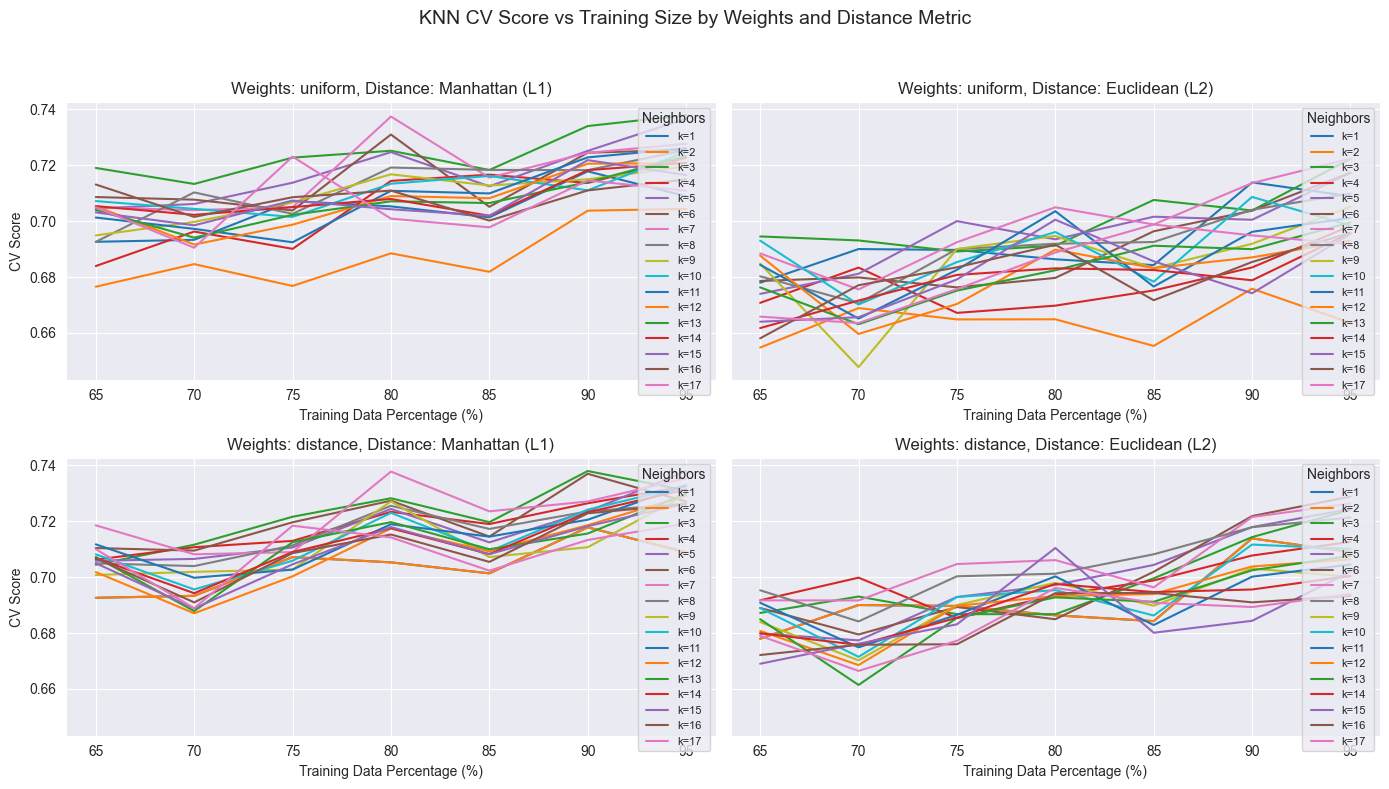


Predicted Best Overall RF Configuration:
Split Size: 0.9
Parameters: {'knn__n_neighbors': 6, 'knn__p': 1, 'knn__weights': 'distance', 'pca__n_components': 0.998}
Mean CV Score: 0.7439
Std CV Score: 0.0466


In [93]:
cv_df = pd.DataFrame(scoreboard_pca_knn)

cv_df['p'] = cv_df['params'].apply(lambda d: d.get('knn__p'))  # 1 = Manhattan, 2 = Euclidean
cv_df['weights'] = cv_df['params'].apply(lambda d: d.get('knn__weights'))
cv_df['n_neighbors'] = cv_df['params'].apply(lambda d: d.get('knn__n_neighbors'))
cv_df['split_size_percent'] = cv_df['split_size'] * 100
cv_df['config'] = cv_df.apply(lambda row: f"k={row['n_neighbors']}", axis=1)

weights = ['uniform', 'distance']
metrics = [1, 2]  # p values
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

for i, weight in enumerate(weights):
    for j, p_val in enumerate(metrics):
        subset = cv_df[(cv_df['weights'] == weight) & (cv_df['p'] == p_val)]
        pivot_df = subset.pivot_table(index='split_size_percent', columns='config', values='mean_test_score')

        ax = axes[i][j]
        sorted_configs = sorted(pivot_df.columns, key=lambda x: int(x.split('=')[1]))
        for config in sorted_configs:
            ax.plot(pivot_df.index, pivot_df[config], label=config)


        label = 'Manhattan (L1)' if p_val == 1 else 'Euclidean (L2)'
        ax.set_title(f"Weights: {weight}, Distance: {label}")
        ax.set_xlabel('Training Data Percentage (%)')
        ax.grid(True)
        ax.legend(title='Neighbors', fontsize=8)

axes[0][0].set_ylabel('CV Score')
axes[1][0].set_ylabel('CV Score')
plt.suptitle('KNN CV Score vs Training Size by Weights and Distance Metric', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

best_entry = cv_df.sort_values(by='mean_test_score', ascending=False).iloc[0]

# Print best configuration
print("\nPredicted Best Overall RF Configuration:")
print(f"Split Size: {best_entry['split_size']}")
print(f"Parameters: {best_entry['params']}")
print(f"Mean CV Score: {best_entry['mean_test_score']:.4f}")
print(f"Std CV Score: {best_entry['std_test_score']:.4f}")

*Best overall Tested PCA+KNN Configuration:*

 Training with 85% of data:
Selected PCA n_components: 14  Best parameters:
`{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance', 'pca__n_components': 0.997}`

| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| bus          | 0.94      | 0.97   | 0.96     | 33      |
| opel         | 0.67      | 0.44   | 0.53     | 32      |
| saab         | 0.60      | 0.81   | 0.69     | 32      |
| van          | 0.93      | 0.90   | 0.92     | 30      |
| **accuracy** |           |        | 0.78     | 127     |
| **macro avg**| 0.79      | 0.78   | 0.77     | 127     |
| **weighted avg** | 0.78  | 0.78   | 0.77     | 127     |


**Logistic Regression**

In [45]:
from sklearn.linear_model import LogisticRegression

scoreboard_log = []
split_sizes = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength < 1000
    'logreg__penalty': ['l1', 'l2', 'elasticnet'], # L1 = sparse, L2 = ridge
    'logreg__solver': ['saga'], # Supports both L1 and L2
    'logreg__l1_ratio': [0.15, 0.5, 0.85]
}

for size in split_sizes:
    print(f"\nTraining with {int(size * 100)}% of data:")

    # Seeded random stratified sampling
    X_sub, X_val, y_sub, y_val = train_test_split(scaled_df, Y, train_size=size, stratify=Y, random_state=42)

    # Pipeline with scaler and LGREG
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=10000))
        ])

    # Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=1)
    grid_search.fit(X_sub, y_sub)

    # Evaluation
    Y_pred = grid_search.predict(X_val)
    print("Best parameters:", grid_search.best_params_)
    print(classification_report(y_val, Y_pred))

    results = grid_search.cv_results_
    for i in range(len(results['params'])):
        entry = {
            'split_size': size,
            'params': results['params'][i],
            'mean_test_score': results['mean_test_score'][i],
            'std_test_score': results['std_test_score'][i],
            'rank_test_score': results['rank_test_score'][i]
        }
        scoreboard_log.append(entry)


Training with 65% of data:
Fitting 10 folds for each of 45 candidates, totalling 450 fits


C:\Users\stefd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best parameters: {'logreg__C': 100, 'logreg__l1_ratio': 0.15, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
              precision    recall  f1-score   support

         bus       0.96      0.96      0.96        77
        opel       0.73      0.66      0.70        74
        saab       0.72      0.76      0.74        76
         van       0.94      0.97      0.96        70

    accuracy                           0.84       297
   macro avg       0.84      0.84      0.84       297
weighted avg       0.84      0.84      0.84       297


Training with 70% of data:
Fitting 10 folds for each of 45 candidates, totalling 450 fits
Best parameters: {'logreg__C': 10, 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}
              precision    recall  f1-score   support

         bus       1.00      0.95      0.98        65
        opel       0.74      0.67      0.70        64
        saab       0.72      0.80      0.76        65
         van       0.94  

C:\Users\stefd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best parameters: {'logreg__C': 1, 'logreg__l1_ratio': 0.15, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
              precision    recall  f1-score   support

         bus       0.98      0.96      0.97        55
        opel       0.70      0.62      0.66        53
        saab       0.70      0.78      0.74        54
         van       0.94      0.96      0.95        50

    accuracy                           0.83       212
   macro avg       0.83      0.83      0.83       212
weighted avg       0.83      0.83      0.83       212


Training with 80% of data:
Fitting 10 folds for each of 45 candidates, totalling 450 fits


C:\Users\stefd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best parameters: {'logreg__C': 1, 'logreg__l1_ratio': 0.15, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
              precision    recall  f1-score   support

         bus       0.98      0.98      0.98        44
        opel       0.72      0.55      0.62        42
        saab       0.68      0.82      0.74        44
         van       0.95      0.97      0.96        40

    accuracy                           0.83       170
   macro avg       0.83      0.83      0.83       170
weighted avg       0.83      0.83      0.83       170


Training with 85% of data:
Fitting 10 folds for each of 45 candidates, totalling 450 fits


C:\Users\stefd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best parameters: {'logreg__C': 100, 'logreg__l1_ratio': 0.15, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
              precision    recall  f1-score   support

         bus       1.00      1.00      1.00        33
        opel       0.76      0.59      0.67        32
        saab       0.71      0.84      0.77        32
         van       0.94      0.97      0.95        30

    accuracy                           0.85       127
   macro avg       0.85      0.85      0.85       127
weighted avg       0.85      0.85      0.85       127


Training with 90% of data:
Fitting 10 folds for each of 45 candidates, totalling 450 fits
Best parameters: {'logreg__C': 1, 'logreg__l1_ratio': 0.85, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}
              precision    recall  f1-score   support

         bus       0.95      0.95      0.95        22
        opel       0.67      0.57      0.62        21
        saab       0.64      0.73      0.68        22
         van       0.95  

C:\Users\stefd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best parameters: {'logreg__C': 100, 'logreg__l1_ratio': 0.15, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
              precision    recall  f1-score   support

         bus       1.00      0.91      0.95        11
        opel       0.62      0.73      0.67        11
        saab       0.70      0.64      0.67        11
         van       0.90      0.90      0.90        10

    accuracy                           0.79        43
   macro avg       0.80      0.79      0.80        43
weighted avg       0.80      0.79      0.79        43



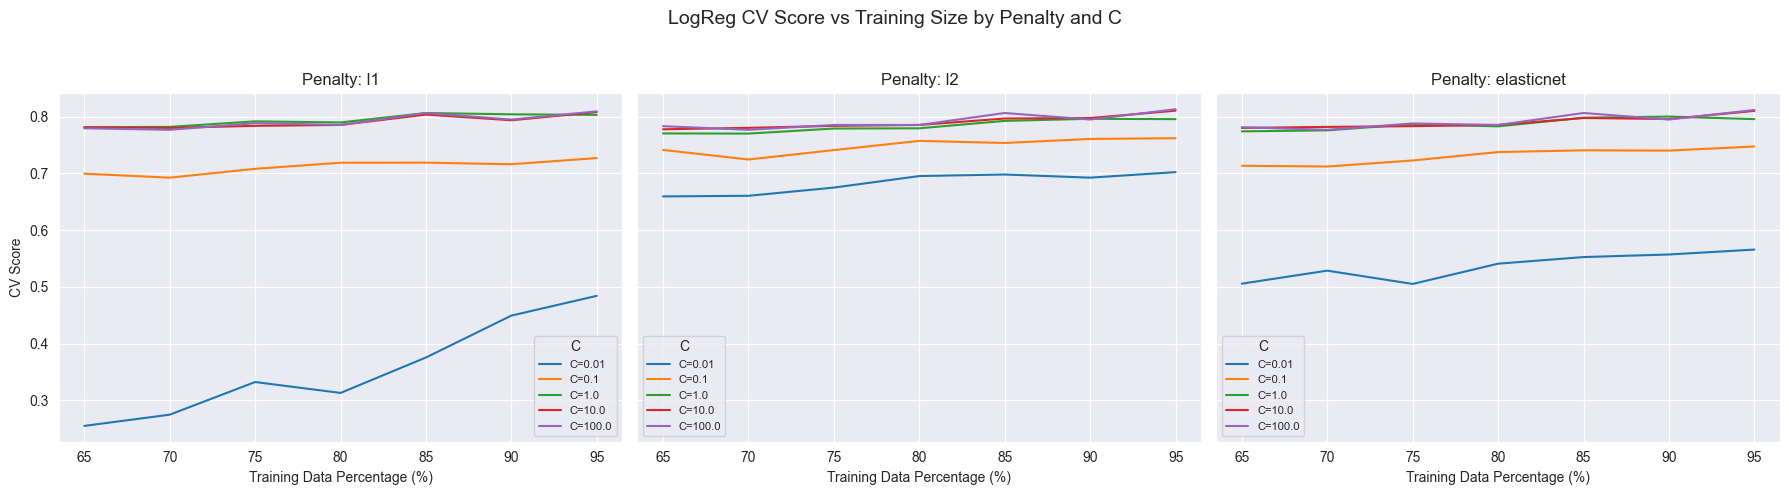


Predicted Best Overall RF Configuration:
Split Size: 0.95
Parameters: {'logreg__C': 100, 'logreg__l1_ratio': 0.85, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Mean CV Score: 0.8132
Std CV Score: 0.0257


In [94]:
cv_df = pd.DataFrame(scoreboard_log)

# Extract parameters
cv_df['penalty'] = cv_df['params'].apply(lambda d: d.get('logreg__penalty'))
cv_df['C'] = cv_df['params'].apply(lambda d: d.get('logreg__C'))
cv_df['split_size_percent'] = cv_df['split_size'] * 100
cv_df['config'] = cv_df.apply(lambda row: f"C={row['C']}", axis=1)

penalties = cv_df['penalty'].unique()
fig, axes = plt.subplots(1, len(penalties), figsize=(6 * len(penalties), 5), sharey=True)

for ax, penalty in zip(axes, penalties):
    pen_df = cv_df[cv_df['penalty'] == penalty]
    pivot_df = pen_df.pivot_table(index='split_size_percent', columns='config', values='mean_test_score')

    # Sort C labels numerically
    sorted_configs = sorted(pivot_df.columns, key=lambda x: float(x.split('=')[1]))
    for config in sorted_configs:
        ax.plot(pivot_df.index, pivot_df[config], label=config)

    ax.set_title(f"Penalty: {penalty}")
    ax.set_xlabel('Training Data Percentage (%)')
    ax.grid(True)
    ax.legend(title='C', fontsize=8)

axes[0].set_ylabel('CV Score')
plt.suptitle('LogReg CV Score vs Training Size by Penalty and C', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

best_entry = cv_df.sort_values(by='mean_test_score', ascending=False).iloc[0]

# Print best configuration
print("\nPredicted Best Overall RF Configuration:")
print(f"Split Size: {best_entry['split_size']}")
print(f"Parameters: {best_entry['params']}")
print(f"Mean CV Score: {best_entry['mean_test_score']:.4f}")
print(f"Std CV Score: {best_entry['std_test_score']:.4f}")

*Best overall Tested LGREG Configuration:*

Training with 70% of data: Best parameters: {'logreg__C': 10, 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}

| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| bus          | 1.00      | 0.95   | 0.98     | 65      |
| opel         | 0.74      | 0.67   | 0.70     | 64      |
| saab         | 0.72      | 0.80   | 0.76     | 65      |
| van          | 0.94      | 0.97   | 0.95     | 60      |
| **accuracy** |           |        | 0.85     | 254     |
| **macro avg**| 0.85      | 0.85   | 0.85     | 254     |
| **weighted avg** | 0.85  | 0.85   | 0.85     | 254     |



